# <center> Идентификация пользователей по посещенным веб-страницам

В этом проекте будет решаться задача идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. По последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать.

Будем использовать данные из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data".

Данные пришли с прокси-серверов Университета Блеза Паскаля и имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>

Задача заключается в том, чтобы по последовательности сайтов предсказать, принадлежит ли эта последовательность интересующему нас пользователю Alice, или другому, задача бинарной классификации.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
PATH_TO_DATA = '.'
SEED = 17

Исходные данные предобработанны таким образом, что представляют из себя таблицы, где строка - последовательность веб-страниц, метки времени захода на соотвествующий сайт и метка пользователя.

In [3]:
time_cols = [f'time{i}' for i in range(1, 11)]
site_cols = [f'site{i}' for i in range(1, 11)]

In [4]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [5]:
train_df.drop_duplicates(inplace=True)
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


# Первичный анализ и предобработка признаков

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253533 entries, 1 to 253561
Data columns (total 21 columns):
site1     253533 non-null int64
time1     253533 non-null object
site2     250079 non-null float64
time2     250079 non-null object
site3     246900 non-null float64
time3     246900 non-null object
site4     244302 non-null float64
time4     244302 non-null object
site5     241811 non-null float64
time5     241811 non-null object
site6     239477 non-null float64
time6     239477 non-null object
site7     237279 non-null float64
time7     237279 non-null object
site8     235206 non-null float64
time8     235206 non-null object
site9     233066 non-null float64
time9     233066 non-null object
site10    231034 non-null float64
time10    231034 non-null object
target    253533 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


Сессии ограничены количеством сайтов (10) или длительностью сессии (30 мин)

Кроме train- и test- таблиц, есть словарь всех сайтов site_dict:

In [7]:
with open('site_dic.pkl', 'rb') as sd:
    site_dict = pickle.load(sd)
id2site = {v:k for (k, v) in site_dict.items()}
print(pd.Series(site_dict)[:10])
print(f'Длина словаря сайтов: {len(site_dict)}')

www.abmecatronique.com                25075
groups.live.com                       13997
majeureliguefootball.wordpress.com    42436
cdt46.media.tourinsoft.eu             30911
www.hdwallpapers.eu                    8104
img378.imageshack.us                  37491
ecologie.nature.free.fr                5462
www.ibcn.intec.ugent.be               35425
kissanime.com                         30151
www.carolineconduiteformation.com     38268
dtype: int64
Длина словаря сайтов: 48371


In [8]:
len(train_df[train_df.target == 0]), len(train_df[train_df.target == 1])

(251236, 2297)

In [9]:
train_df['target'].value_counts(normalize=True)

0    0.99094
1    0.00906
Name: target, dtype: float64

В обучающей выборке классы сильно несбалансированы.

Объединим обучающую и тестовую выборки без меток класса, чтобы производить преобразования и добавление новых признаков:

In [10]:
full_df = pd.concat([train_df.drop('target', axis=1), test_df])
full_df.shape

(336330, 20)

Заменим пропуски сайтов на 0, так как нумерация сайтов в словаре site_dict начинается с единицы:

In [11]:
train_df[site_cols] = train_df[site_cols].fillna(0).astype(int)
full_df[site_cols] = full_df[site_cols].fillna(0).astype(int)
idx = len(train_df)
full_df[site_cols].head(3)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768


In [12]:
full_df[time_cols].head()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
1,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16
3,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24
4,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42
5,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11


# Генерация новых признаков

**Добавим следующие признаки, связанные со временем посещения сайтов:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии) в секундах, сразу его отмасштабируем
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)
- `month` – месяц (то есть месяц в записи минимального timestamp среди десяти)
- `year_month` – в выборке присутствуют записи 2013 и 2014 года, этот признак равен признаку month в 2013, а в 2014 равен 12 + month
- `daypart` – часть дня (с 6-11 – день, с 12-17 – вечер, с 18-23 – ночь, в другое время записей нет)
- `weekend` – индикатор выходных
- `week_of_year` – номер недели в году
- `a_12_13` – наибольшая часть активности Alice приходится на 12-13 часов, индикатор того, началась ли сессия в этот период
- `a_16_18` – признак, аналогичный a_12_13, но интервал времени равен 16-18.

In [13]:
def day_part(hour):
    if 6 <= hour <= 11:
        return 'day'
    elif 12 <= hour <= 17:
        return 'evening'
    elif 18 <= hour <= 23:
        return 'night'

In [14]:
%%time
session_timespan = []
start_hour = []
day_of_week = []
month = []
year_month = []
daypart = []
weekend = []
week_of_year = []
a_12_13 = []
a_16_18 = []
for row in full_df[time_cols].itertuples(index=False):
    row = [x for x in row if str(x) != 'nan']
    row = np.array(row, dtype='datetime64')
    min_time = row.min()
    session_timespan.append(np.log1p((row.max() - min_time).tolist().seconds))
    min_time = min_time.tolist()
    start_hour.append(min_time.hour)
    day_of_week.append(min_time.weekday())
    month.append(min_time.month)
    year_month.append(12 * (min_time.year - 2013) + min_time.month)
    daypart.append(day_part(min_time.hour))
    weekend.append(int(min_time.weekday() > 4))
    week_of_year.append(min_time.isocalendar()[1])
    a_12_13.append(int(12 <= min_time.hour <= 13))
    a_16_18.append(int(16 <= min_time.hour <= 18))

Wall time: 9.27 s


In [15]:
list_features = [session_timespan, start_hour, day_of_week, month, year_month, daypart, weekend,
                 week_of_year, a_12_13, a_16_18]
name_features = ['session_timespan', 'start_hour', 'day_of_week', 'month', 'year_month', 'daypart', 'weekend',
                 'week_of_year', 'a_12_13', 'a_16_18']

In [16]:
for feat, name in zip(list_features, name_features):
    train_df.insert(len(train_df.columns), name, feat[:idx])

Посмотрим на сгенерированные признаки:

Text(0.5, 0.98, 'Распределение длины сессии')

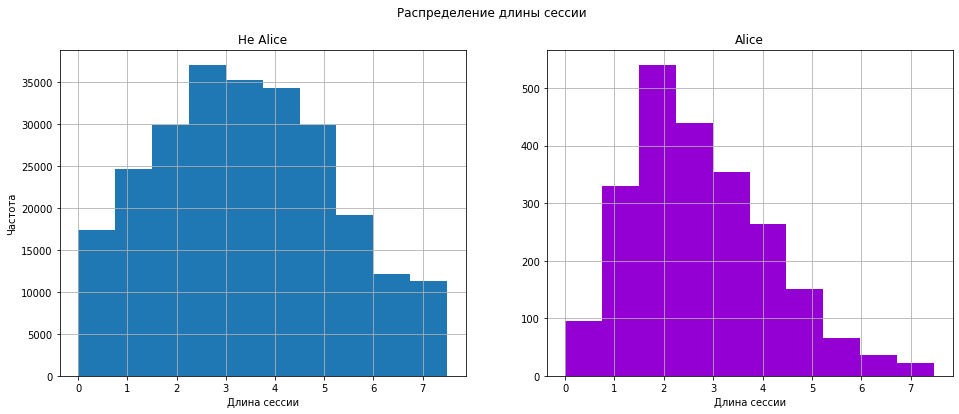

In [17]:
plt.rcParams['axes.grid'] = True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.hist(train_df[train_df.target == 0]['session_timespan'])
ax1.set_xlabel('Длина сессии')
ax1.set_ylabel('Частота')
ax1.set_title('Не Alice')

ax2.hist(train_df[train_df.target == 1]['session_timespan'], color='darkviolet')
ax2.set_title('Alice')
ax2.set_xlabel('Длина сессии')
fig.suptitle('Распределение длины сессии')

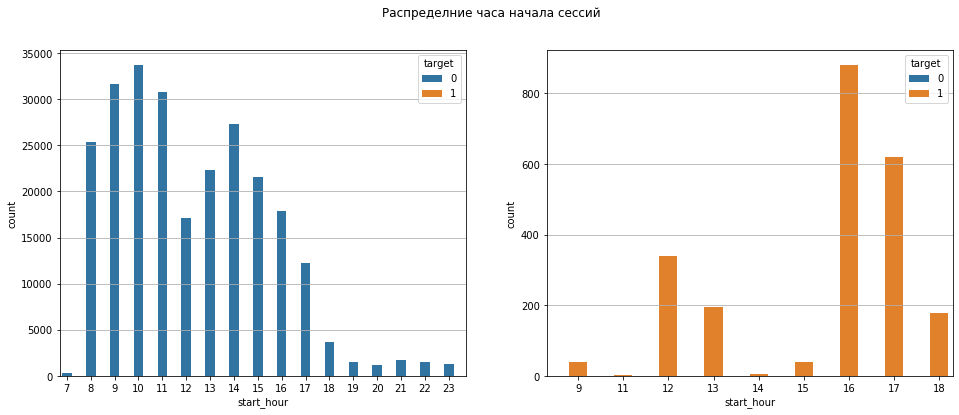

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1 = sns.countplot(x=train_df[train_df.target==0].start_hour, hue=train_df.target, ax=ax1);
ax2 = sns.countplot(x=train_df[train_df.target==1].start_hour, hue=train_df.target, ax=ax2);
ax1.set_xticks(np.arange(len(train_df[train_df.target==0].start_hour.unique())) - 0.2)
ax2.set_xticks(np.arange(len(train_df[train_df.target==1].start_hour.unique())) + 0.2)
fig.suptitle('Распределние часа начала сессий');

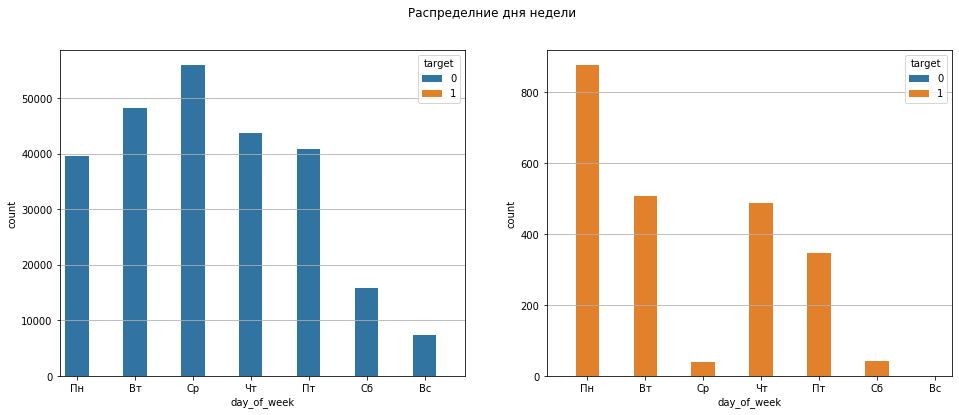

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
ax1 = sns.countplot(x=train_df[train_df.target==0].day_of_week, hue=train_df.target, ax=ax1);
ax2 = sns.countplot(x=train_df[train_df.target==1].day_of_week, hue=train_df.target, ax=ax2);
ax1.set_xticks(np.arange(7) - 0.2)
ax1.set_xticklabels(days)
ax2.set_xticks(np.arange(7) + 0.2)
ax2.set_xticklabels(days)
fig.suptitle('Распределние дня недели');

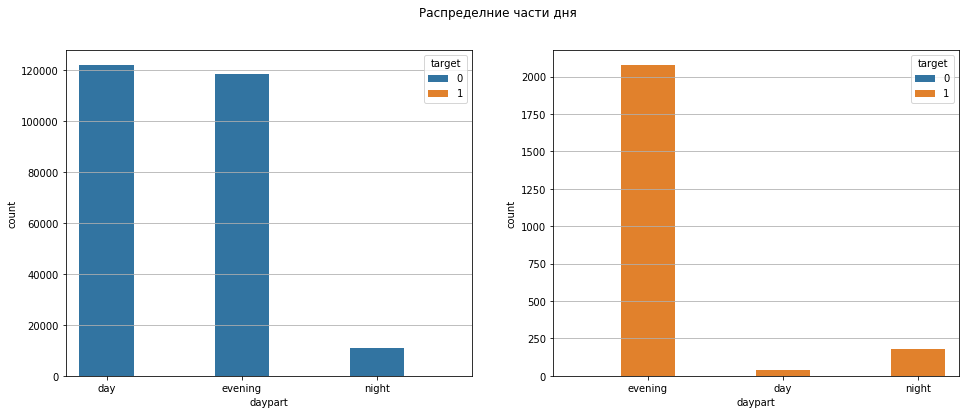

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1 = sns.countplot(x=train_df[train_df.target==0].daypart, hue=train_df.target, ax=ax1);
ax2 = sns.countplot(x=train_df[train_df.target==1].daypart, hue=train_df.target, ax=ax2);
ax1.set_xticks(np.arange(len(train_df[train_df.target==0].daypart.unique())) - 0.2)
ax2.set_xticks(np.arange(len(train_df[train_df.target==1].daypart.unique())) + 0.2)
fig.suptitle('Распределние части дня');

Видно, что с помощью полученных признаков можно отличить Alice от остальных пользователей.

**Добавим признаки, обозначающие количество заходов в сессии на сайт, название которого соответствует признаку:**
- `vk.com`
- `plus.google.com`
- `mail.google.com`

In [21]:
site_vk = site_dict['vk.com']
site_plusgoogle = site_dict['plus.google.com']
site_gmail = site_dict['mail.google.com']

In [22]:
%%time
vkcom = []
plusgoogle = []
gmail = []
for row in full_df[site_cols].itertuples(index=False):
    vkcom.append(row.count(site_vk))
    plusgoogle.append(row.count(site_plusgoogle))
    gmail.append(row.count(site_gmail))
    
train_df.insert(len(train_df.columns), 'vkcom', vkcom[:idx])
train_df.insert(len(train_df.columns), 'plusgoogle', plusgoogle[:idx])
train_df.insert(len(train_df.columns), 'gmail', gmail[:idx])

Wall time: 708 ms


Среднее количество заходов на сайты у других пользователей и Alice:

In [23]:
round(train_df[train_df.target == 0]['vkcom'].mean(), 5), round(train_df[train_df.target == 1]['vkcom'].mean(), 5)

(0.00412, 0.12451)

In [24]:
round(train_df[train_df.target == 0]['plusgoogle'].mean(), 5), round(train_df[train_df.target == 1]['plusgoogle'].mean(), 5)

(0.12186, 0.0)

In [25]:
round(train_df[train_df.target == 0]['gmail'].mean(), 5), round(train_df[train_df.target == 1]['gmail'].mean(), 5)

(0.14002, 0.0)

Отметим сайты, на которые Alice заходит чаще всего:

In [26]:
top_sites_alice = pd.Series(train_df[train_df.target==1][site_cols].values.flatten()
                           ).value_counts().sort_values(ascending=False).head(10)
print('id сайта и частота захода:')
top_sites_alice

id сайта и частота захода:


77     1382
80     1354
76     1307
29      897
21      857
81      609
879     522
22      522
75      451
82      447
dtype: int64

In [27]:
top_site_alice = [id2site[site] for site in top_sites_alice.index]
print('Названия сайтов:')
top_site_alice

Названия сайтов:


['i1.ytimg.com',
 's.youtube.com',
 'www.youtube.com',
 'www.facebook.com',
 'www.google.fr',
 'r4---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'apis.google.com',
 's.ytimg.com',
 'r2---sn-gxo5uxg-jqbe.googlevideo.com']

In [28]:
list_features = [session_timespan, start_hour, day_of_week, month, year_month, daypart, weekend,
                 week_of_year, a_12_13, a_16_18, plusgoogle, gmail, vkcom]
name_features = ['session_timespan', 'start_hour', 'day_of_week', 'month', 'year_month', 'daypart', 'weekend',
                 'week_of_year', 'a_12_13', 'a_16_18', 'plusgoogle', 'gmail', 'vkcom']

In [29]:
additional_data_df = pd.DataFrame(index = full_df.index)
for feat, name in zip(list_features, name_features):
    additional_data_df.insert(len(additional_data_df.columns), name, feat)

In [30]:
additional_data_df.head()

,session_timespan,start_hour,day_of_week,month,year_month,daypart,weekend,week_of_year,a_12_13,a_16_18,plusgoogle,gmail,vkcom
session_id,,,,,,,,,,,,,
1,0.000000,10,3,2,14,day,0,8,0,0,0,0,0
2,3.295837,11,5,2,14,day,1,8,0,0,0,0,0
3,2.079442,16,0,12,12,evening,0,51,0,1,0,0,0
4,5.602119,10,4,3,15,day,0,13,0,0,0,0,0
5,5.509388,10,4,2,14,day,0,9,0,0,0,0,0


## Преобразуем категориальные признаки

In [31]:
add_data_df = pd.get_dummies(additional_data_df, columns=['year_month', 'month', 'start_hour', 'week_of_year', 'day_of_week',
                                                          'daypart'])
add_data_df.head()

,session_timespan,weekend,a_12_13,a_16_18,plusgoogle,gmail,vkcom,year_month_1,year_month_2,year_month_3,...,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,daypart_day,daypart_evening,daypart_night
session_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,3.295837,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,2.079442,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,5.602119,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5,5.509388,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


## Векторизуем данные сайтов и получим их имена

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 7), max_features = 200000)
full_df[site_cols][:idx].to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
full_df[site_cols][idx:].to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)
with open('train_sessions_text.txt') as inp_train_file:
    X_train_sites = vectorizer.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_sites = vectorizer.transform(inp_test_file)
X_train_sites.shape, X_test_sites.shape

count_vec_feat = vectorizer.get_feature_names()
for n in range(len(count_vec_feat)):
    features = count_vec_feat[n].split()
    features = [id2site[int(x)] for x in features]
    count_vec_feat[n] = ' '.join(features)

## Создадим разбиение с помощью TimeSeriesSplit дла кросс-валидации:

In [33]:
time_split = TimeSeriesSplit(n_splits=10)

# Обучение модели

Добавим созданные признаки:

In [34]:
train_sparse = hstack([X_train_sites, add_data_df[:idx].values], 'csr')
test_sparse = hstack([X_test_sites, add_data_df[idx:].values], 'csr')
y = train_df['target']

Попробуем несколько различных моделей с параметрами по умолчанию для оценки качества:

In [35]:
logit = LogisticRegression(random_state=SEED, n_jobs = 1)
sgd = SGDClassifier(random_state=SEED, loss='log', n_jobs = -1)
xgboost = xgb.XGBClassifier(random_state=SEED, eval_metric='auc', n_jobs=-1)

In [36]:
cv_scores_logit = cross_val_score(logit, train_sparse, y, scoring = 'roc_auc', cv = time_split, n_jobs=-1, verbose = 1)
cv_scores_logit, cv_scores_logit.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.8s finished


(array([0.96608078, 0.97256193, 0.98523684, 0.97911951, 0.98242844,
        0.98727136, 0.98885921, 0.98200298, 0.98881387, 0.98896074]),
 0.9821335662749421)

In [37]:
cv_scores_sgd = cross_val_score(sgd, train_sparse, y, scoring = 'roc_auc', cv = time_split, n_jobs=-1, verbose = 1)
cv_scores_sgd, cv_scores_sgd.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


(array([0.95900471, 0.95647869, 0.96573753, 0.95410234, 0.96496016,
        0.96486586, 0.96881473, 0.94600895, 0.9622356 , 0.95854586]),
 0.9600754431554291)

In [38]:
cv_scores_xgb = cross_val_score(xgboost, train_sparse, y, scoring = 'roc_auc', cv = time_split, n_jobs=-1, verbose = 1)
cv_scores_xgb, cv_scores_xgb.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


(array([0.98081808, 0.98898   , 0.99629394, 0.99421977, 0.99384963,
        0.99627252, 0.99654823, 0.99504766, 0.9972098 , 0.99572257]),
 0.9934962190546848)

На практике счет XGBoost меньше счета логистической регрессии, поэтому используем её.

## Настройка параметров модели, построение кривых валидации.

In [39]:
def plot_validation_curves(param_values, grid_cv_results_):
    f, ax = plt.subplots(figsize=(15, 10))
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()
    return ax

In [41]:
logit_grid1 = {
    'C': np.logspace(-2, 1, 10),
    'solver': ['liblinear', 'lbfgs']
}
gs1 = GridSearchCV(logit, param_grid = logit_grid1, cv = time_split, scoring = 'roc_auc', n_jobs=-1,
                  return_train_score = True, verbose = 1)
gs1.fit(train_sparse, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=1, penalty='l2',
                                          random_state=17, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                         'solver': ['liblinear', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, ret

In [42]:
gs1.best_score_, gs1.best_params_

(0.9886895364142079, {'C': 10.0, 'solver': 'liblinear'})

In [44]:
logit_grid2 = {
    'C': [1, 5] + list(range(10, 20, 1))
}
logit = LogisticRegression(random_state=SEED, solver = 'liblinear', n_jobs = 1)
gs2 = GridSearchCV(logit, param_grid = logit_grid2, cv = time_split, scoring = 'roc_auc', n_jobs=-1,
                  return_train_score = True, verbose = 1)
gs2.fit(train_sparse, y)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.0min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=1, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [45]:
gs2.best_score_, gs2.best_params_

(0.9888112895542708, {'C': 18})

Text(0.5, 1.0, 'Кривые валидации и обучения')

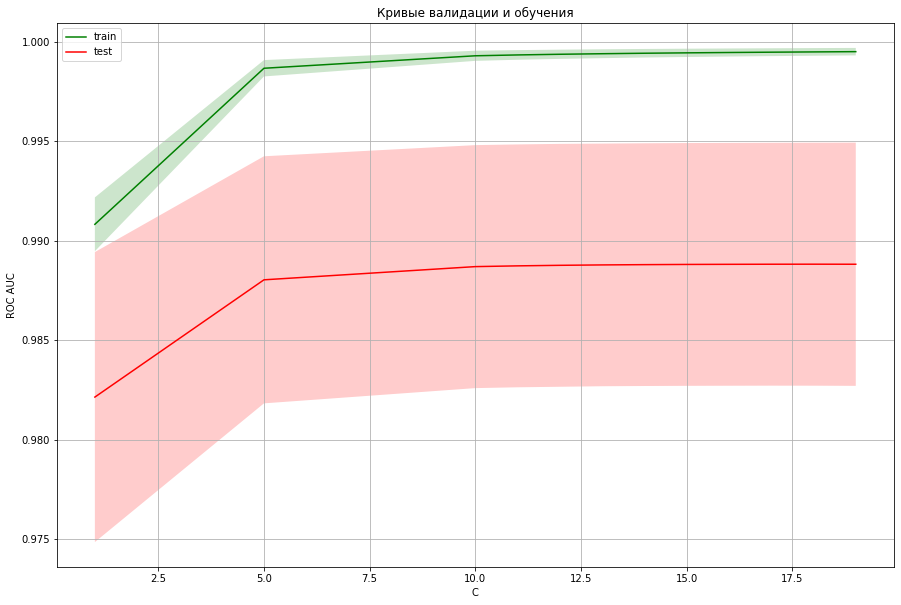

In [46]:
ax = plot_validation_curves(logit_grid2['C'], gs2.cv_results_)
ax.set_xlabel('C')
ax.set_ylabel('ROC AUC')
ax.set_title('Кривые валидации и обучения')

Отобразим веса модели с помощью eli5:

In [47]:
logit = gs2.best_estimator_
logit.fit(train_sparse, y)

LogisticRegression(C=18, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=1, penalty='l2', random_state=17,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [48]:
eli5.show_weights(estimator=logit, feature_names=count_vec_feat + list(add_data_df.columns), top = (30, 20))

Weight?,Feature
+16.034,cid-ed6c3e6a5c6608a4.users.storage.live.com
+11.903,vk.com
+11.415,www.activistpost.com
+9.821,media.meltyfood.fr
+9.815,www.express.co.uk
+9.562,pagesmed-assets.s3.amazonaws.com
+9.346,www.pagesmed.com
+8.962,inskin01.wt-eu02.net
+8.383,tru.am
+8.381,betacie.cachefly.net


Cреди важных признаков находятся сайты, популярные у Alice, или, наоборот, те, на которые она не заходила никогда. Также присутствуют сгенерированные признаки.

In [49]:
test_pred = logit.predict_proba(test_sparse)[:, 1]

In [50]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels, index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [51]:
write_to_submission_file(test_pred, 'submission.csv')

# Заключение. Итоги

В ходе проекта было реализованы следующие шаги:
- анализ и предобработка признаков
- генерация новых признаков, их масштабирование, преобразование категориальных признаков
- выбор модели для обучения, настройка параметров модели, анализ весов модели